In [1]:
import numpy as np
import pandas as pd
from os import walk, listdir
from PIL import Image
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input, decode_predictions
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Activation, GlobalAveragePooling2D
from keras.metrics import AUC, Precision, Recall
from keras.utils import np_utils
from sklearn.utils import shuffle
import json

In [2]:
classes = ["Cat", "Dog", "Bird"]
base_path = '../fiftyone/open-images-v6/'
class_map = pd.read_csv(base_path + 'train/metadata/classes.csv', names=['id', 'name'])
class_map.head()

,id,name
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [3]:
mask = class_map['name'].isin(classes)
labels = {}
for index, row in class_map[mask].iterrows():
    labels[row['name']] = row['id']
labels['long_exposure'] = 'custom'

In [4]:
encoding = {k:v for v, k in enumerate(labels.values())}
encoding

{'/m/015p6': 0, '/m/01yrx': 1, '/m/0bt9lr': 2, 'custom': 3}

In [5]:
n_classes = len(encoding)
def get_categorical(row):
    x = np.zeros(n_classes)
    x[row] = 1
    return x

In [6]:
def get_dataset(dType):
    img_labels = pd.read_csv(base_path + dType + '/labels/classifications.csv')
    img_labels = img_labels[img_labels['Confidence'] == 1]
    mask = img_labels['LabelName'].isin(labels.values())
    img_labels = img_labels[mask]
    images = []
    for (dirpath, dirnames, filenames) in walk(base_path + dType + '/data'):
        images.append(filenames)
    images = [i.split('.')[0] for i in images[0]]
    mask = img_labels['ImageID'].isin(images)
    img_labels = img_labels[mask]
    img_labels_new = img_labels.copy()
    img_labels_new['ImageID'] = img_labels_new['ImageID'].apply(lambda row: dType + '/data/' + row + '.jpg')
    img_labels_new = img_labels_new.drop(['Confidence', 'Source'], axis=1)
    img_labels_new = img_labels_new.replace(encoding)
    img_labels_new['LabelName'] = img_labels_new['LabelName'].apply(lambda row: get_categorical(row))
    return img_labels_new

In [7]:
labels_train = get_dataset('train')
labels_test = get_dataset('test')
labels_validation = get_dataset('validation')

In [8]:
labels_train.head()

,ImageID,LabelName
950,train/data/000020780ccee28d.jpg,"[0.0, 1.0, 0.0, 0.0]"
2647,train/data/0000530c47410921.jpg,"[1.0, 0.0, 0.0, 0.0]"
4100,train/data/0000862a233105cc.jpg,"[1.0, 0.0, 0.0, 0.0]"
5171,train/data/0000b9fcba019d36.jpg,"[0.0, 0.0, 1.0, 0.0]"
5335,train/data/0000bf2838ee5aeb.jpg,"[0.0, 0.0, 1.0, 0.0]"


In [9]:
def getExtraData(dType):
    long_exposure_path = 'long_exposure/' + dType
    images = []
    for img in listdir(base_path + long_exposure_path):
        images.append(long_exposure_path + '/' + img)
    long_labels = [3] * len(images)
    df = pd.DataFrame({
        'ImageID': images,
        'LabelName': long_labels
    })
    df['LabelName'] = df['LabelName'].apply(lambda row: np_utils.to_categorical(row, num_classes=n_classes))
    return df

In [10]:
def getExtraData2(dType):
    catdog_path = 'cat_dog/' + dType
    images = []
    for img in listdir(base_path + catdog_path):
        images.append(catdog_path + '/' + img)
    long_labels = [[1, 2]] * len(images)
    df = pd.DataFrame({
        'ImageID': images,
        'LabelName': long_labels
    })
    df['LabelName'] = df['LabelName'].apply(lambda row: get_categorical(row))
    return df

In [11]:
long_train = getExtraData('train')
long_test = getExtraData('test')
long_validation = getExtraData('validation')

In [12]:
# Combine data with long exposure images
labels_train = pd.concat([labels_train, long_train])
labels_test = pd.concat([labels_test, long_test])
labels_validation = pd.concat([labels_validation, long_validation])

In [13]:
cd_train = getExtraData2('train')
labels_train = pd.concat([labels_train, cd_train])

In [14]:
# Shuffle data
labels_train = labels_train.sample(frac=1)
labels_test = labels_test.sample(frac=1)
labels_validation = labels_validation.sample(frac=1)

In [15]:
labels_train.count()

ImageID      8178
LabelName    8178
dtype: int64

In [16]:
print(labels_train.shape, labels_test.shape, labels_validation.shape)

(8178, 2) (1923, 2) (1919, 2)


In [17]:
labels_train.head()

,ImageID,LabelName
464058,train/data/067a1320bb1639d5.jpg,"[0.0, 0.0, 1.0, 0.0]"
377543,train/data/04895a3640c373d8.jpg,"[1.0, 0.0, 0.0, 0.0]"
782788,train/data/0e6f40d8728faffe.jpg,"[1.0, 0.0, 0.0, 0.0]"
603499,train/data/09d82b7a6d6d8da9.jpg,"[1.0, 0.0, 0.0, 0.0]"
809633,train/data/0f1dbc509d2cd10c.jpg,"[1.0, 0.0, 0.0, 0.0]"


In [18]:
X_train = labels_train['ImageID'].to_numpy()
y_train = labels_train['LabelName'].to_numpy()
X_val = labels_validation['ImageID'].to_numpy()
y_val = labels_validation['LabelName'].to_numpy()

In [19]:
abc = np.array([0, 1, 1, 0], dtype=np.float32)
count = 0

for l in labels_train['LabelName']:
    if np.array_equal(l, abc):
        count += 1
print(count)

160


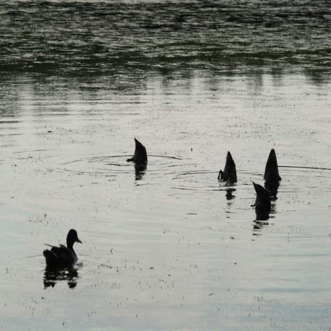

In [20]:
im = Image.open(base_path + X_train[4])
im = im.resize(size=(331,331))
display(im)

In [22]:
def get_images(X_label, y, augment = False):
    X = []
    Y = []
    for i, id in enumerate(X_label):
        im = Image.open(base_path + id)
        im = im.resize(size=(331,331))
        im = np.asarray(im)
        im_processed = preprocess_input(im)
        if im_processed.shape == (331, 331, 3):
            X.append(im_processed)
            if augment:
                im_flipped = np.fliplr(im_processed)
                im_noise = im_processed + np.random.normal(0, 0.05, im_processed.shape)
                X.append(im_flipped)
                X.append(im_noise)
                Y.append(y[i])
                Y.append(y[i])
            Y.append(y[i])
    return shuffle(np.array(X), np.array(Y), random_state=0)


In [23]:
base_model = NASNetLarge(weights='imagenet', include_top=True)

In [24]:
for layer in base_model.layers:
    layer.trainable = False

In [25]:
for layer in base_model.layers[-3:]:
    layer.trainable = True

In [26]:
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4, activation='sigmoid'))

In [27]:
auc = AUC(multi_label=True, thresholds=[0.4])
precision = Precision(thresholds=[0.4])
recall = Recall(thresholds=[0.4])
def AUC_metric(y_true, y_pred):
    return auc(y_true, y_pred)

# def precision_metric(y_true, y_pred):
#     return precision(y_true, y_pred)

# def recall_metric(y_true, y_pred):
#     return recall(y_true, y_pred)

In [28]:
from sklearn.metrics import accuracy_score
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[AUC_metric])

In [29]:
batch_size = 256
validation_batch = 64
n_itr = int(np.ceil(len(X_train)/200))
for i in range(n_itr):
    print("Iteration", i + 1, "of", n_itr)
    X = X_train[i: i + batch_size]
    Y = y_train[i: i + batch_size]
    X, Y = get_images(X, Y, True)
    val_x, val_y = get_images(X_val[i: i + validation_batch], y_val[i: i + validation_batch])
    model.fit(X, Y, validation_data=(val_x, val_y))

Iteration 1 of 41
24/24 [==============================] - 218s 8s/step - loss: 0.6685 - AUC_metric: 0.5408 - val_loss: 0.6724 - val_AUC_metric: 0.5576
Iteration 2 of 41
24/24 [==============================] - 189s 8s/step - loss: 0.5290 - AUC_metric: 0.5792 - val_loss: 0.6509 - val_AUC_metric: 0.6032
Iteration 3 of 41
24/24 [==============================] - 192s 8s/step - loss: 0.4121 - AUC_metric: 0.6361 - val_loss: 0.6273 - val_AUC_metric: 0.6582
Iteration 4 of 41
24/24 [==============================] - 191s 8s/step - loss: 0.3347 - AUC_metric: 0.6833 - val_loss: 0.5970 - val_AUC_metric: 0.6996
Iteration 5 of 41
24/24 [==============================] - 190s 8s/step - loss: 0.2849 - AUC_metric: 0.7176 - val_loss: 0.5577 - val_AUC_metric: 0.7337
Iteration 6 of 41
24/24 [==============================] - 196s 8s/step - loss: 0.2463 - AUC_metric: 0.7482 - val_loss: 0.5194 - val_AUC_metric: 0.7603
Iteration 7 of 41
24/24 [==============================] - 193s 8s/step - loss: 0.2207 -

In [30]:
model.save('./model')
with open('model/labels.json', 'w+') as f:
    json.dump(labels, f)

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


In [31]:
X_test = labels_test['ImageID'].to_numpy()
y_test = labels_test['LabelName'].to_numpy()
X_test, Y_test = get_images(X_test, y_test)
loss, auc_score = model.evaluate(X_test, Y_test)
print(loss, auc_score)

60/60 [==============================] - 404s 7s/step - loss: 0.0520 - AUC_metric: 0.9249
0.0519564263522625 0.9249048233032227
